### Este script parte sirve para pasar un inp con material compuesto definido con ejes tipo node to offset a ejes rectangular. Parte de un inp traducido de un bdf en el que estén definidos los ejes materiales en los elementos
-->abq2018 fromNastran distribution=OFF job=V53585930201_FR095_LW_R_fromNASTRAN
Devuelve el inp adecuado para utilizar con la herramienta de mapping Mapeador_2d_v04
xxxxxx

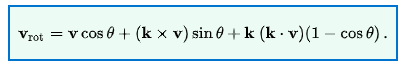

In [2]:
import numpy as np
def rotar(v,eje,theta):
    """thetha in degress"""
    W=np.radians(theta)
    v_array=np.array(v)
    eje_array=np.array(eje)
    v_norm=v_array/np.linalg.norm(v_array)
    eje_norm=eje_array/np.linalg.norm(eje_array)
    return v_norm*np.cos(W)+np.cross(eje_norm,v_norm)*np.sin(W)+eje_norm*np.dot(eje_norm,v_norm)*(1-np.cos(W))
def pro_plane(vec,plane):
    u=np.array(vec)
    n=np.array(plane)
    n_norm = np.sqrt(sum(n**2))   
    proj_of_u_on_n = (np.dot(u, n)/n_norm**2)*n
    return u - proj_of_u_on_n
def ang_lam(eje1,plane,eje_ori):
    eje_proy=pro_plane(eje_ori,plane)
    w=np.array(eje1)
    unit_vector_1 = w / np.linalg.norm(w)
    unit_vector_2 = eje_proy / np.linalg.norm(eje_proy)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    ang_axes = np.degrees(np.arccos(dot_product))
    return -ang_axes*np.sign(np.dot(np.cross(unit_vector_1,unit_vector_2),plane))

In [3]:
import scipy as sp
import numpy as np
import time
import sys
import pandas as pd
inittime = time.time()
def leer_input(inp):
    ###funcion que devuelve los diccionarios de elementos, nodos y sets###
    entrada = open(inp, 'r')
    inp_input = entrada.readlines()
    ###node cord== diccionario de nodos con sus coordenadas###
    node_cord = {}
    ###node_elem===diccinario que asigna a cada nodo todos los elementos que están unidos
    node_elem = {}
    ###elements== diccinario que guarda para cada elemento, el tipo que es, los nodos que tiene y los sets a
    ###los que pertenece
    elements = {}
    elsets = {}
    nsets = {}
    tipo = ""
    linea1 = True
    entrar = ""
    for linea in inp_input:
        if entrar == "nodo":
            if linea[0] != "*":
                temp_l = linea.strip().replace(" ", "").split(",")
                node_cord[temp_l[0]] = [float(k) for k in temp_l[1:4]]
                if entrar2==True:
                    nsets[nset] = nsets[nset] + [temp_l[0]]
                continue
            else:
                if linea[0:2]!='**':
                    entrar = ""
        if entrar == "element":
        ###elements=[tipo,[lista_de nodos],[list de sets],[cord de centroide],[direc_spos]]
            if linea[0] != "*":
                if tipo == "SC8R":
                    if linea1 == True:
                        temp_l = linea.strip().replace(" ", "").split(",")
                        elements[temp_l[0]] = [tipo, temp_l[1:8], [],[],[]]
                        linea1 = False
                    if linea1 == False:
                        elements[temp_l[0]][1].append(linea.strip())
                        linea1 = True
                        for j in elements[temp_l[0]][1]:
                            try:
                                node_elem[j] = node_elem[j] + [temp_l[0]]
                            except (AttributeError, KeyError):
                                node_elem[j] = [temp_l[0]]
                    
                if tipo in ["SC6R","S4","S4R","S3","S3R"]:
                    temp_l = linea.strip().replace(" ", "").split(",")
                    elements[temp_l[0]] = [tipo, temp_l[1:], [],[]]
                    for j in elements[temp_l[0]][1]:
                        try:
                            node_elem[j] = node_elem[j] + [temp_l[0]]
                        except (AttributeError, KeyError):
                            node_elem[j] = [temp_l[0]]
                    
                if entrar2==True:
                    elsets[elset] = elsets[elset] + [temp_l[0]]
                continue
            else:
                if linea[0:2]!='**':
                    entrar = ""
        if entrar == "elset":
            if linea[0] != "*":
                temp_l = linea.strip().replace(" ", "").split(",")
                temp_l2 = [i for i in temp_l if i != ""]
                elsets[elset] = elsets[elset] + temp_l2
                continue
            else:
                if linea[0:2]!='**':
                    entrar = ""
        if entrar == "nset":
            if linea[0] != "*":
                temp_l = linea.strip().replace(" ", "").split(",")
                temp_l2 = [i for i in temp_l if i != ""]
                nsets[nset] = nsets[nset] + temp_l2
                continue
            else:
                if linea[0:2]!='**':
                    entrar = ""
        if linea[:5].casefold() == "*node" and 'output' not in linea.casefold():
            entrar = "nodo"
            if 'nset' in linea.casefold():
                entrar2=True
                nset = linea.strip().split("=")[-1].strip()
                nsets[nset] = []
            else:
                entrar2=False

        if linea[:8].casefold()  == "*element" and 'output' not in linea.casefold():
            entrar = "element"
            linea1 = True
            tipo = linea.strip().split(",")[1].split("=")[-1]
            if 'elset' in linea.casefold():
                entrar2=True
                elset = linea.strip().split("=")[-1].strip()
                elsets[elset] = []
            else:
                entrar2=False
        if linea[:6].casefold()  == "*elset":
            elset = linea.strip().split("=")[-1].strip()
            elsets[elset] = []
            entrar = "elset"
        if linea[:5].casefold()  == "*nset":
            nset = linea.strip().split("=")[-1].strip()
            nsets[nset] = []
            entrar = "nset"
    entrada.close()
    ###bucle para asignar a cada elemento los sets en los que aparece
    for k in elsets.keys():
        for i in elsets[k]:
            try:

                elements[i][2].append(k)
            except KeyError:
                log = open('log_match.log', 'a')
                log.writelines(["Elem " + i + " appears in ELSET but is not defined\n"])
                log.close()
                continue
    ###bucle para calcular el centroide de cada elemento
    for e in elements.keys():
        x=0.
        y=0.
        z=0.
        k=0
        for n in elements[e][1]:
            x=x+node_cord[n][0]
            y=y+node_cord[n][1]
            z=z+node_cord[n][2]
            k=k+1
        elements[e][3]=[x/k,y/k,z/k]
    return node_cord, node_elem, elements, elsets, nsets

In [15]:


def mayor_comp(vec):
    xp=[1.,0.,0.]
    yp=[0.,1.0,0.]
    zp=[0.,0.,1.]
    b=[abs(x) for x in vec]
    pos=b.index(max(b))
    if pos==0:
        plane=xp
        tipo='x'
    if pos==1:
        plane=yp
        tipo='y'
    if pos==2:
        plane=zp
        tipo='z'
    return plane,tipo
def elem_angulo(inp,s_o,o_a):
    nc,ne,el,elsets,nsets=leer_input(inp)
    vecs={}
    thetas={}
    current_axis={}
    pcomp_set={}
    dirs={}
    for k in elsets.keys():
        if k.startswith("PCOMP"):
            n01= el[elsets[k][0]][1][0]
            n02= el[elsets[k][0]][1][1]
            n03=el[elsets[k][0]][1][2]
            c01=np.array(nc[n01])
            c02=np.array(nc[n02])
            c03=np.array(nc[n03])
            plane0=np.cross(c02-c01,c03-c01)
            eje_el0=c02-c01
            for j in elsets[k]:
#                 if j=='1177':
                    n1= el[j][1][0]
                    n2= el[j][1][1]
                    n3=el[j][1][2]
                    c1=np.array(nc[n1])
                    c2=np.array(nc[n2])
                    c3=np.array(nc[n3])
                    plane=np.cross(c2-c1,c3-c1)
                    eje_el=c2-c1
                    giro_eje_el=rotar(eje_el,plane,o_a[s_o[k]])
#                     print("plano: "+ str(plane))
#                     print("eje el: "+str(eje_el))
#                     print("giro_el "+str(giro_eje_el))
                    new_plane,tipo=mayor_comp(plane)
                    vecs[j]=pro_plane(giro_eje_el,new_plane)
#                     print("poryeccion :"+str(vecs[j]))
                    signo=1
                    if tipo=='x':
                    #angulos con respecto al eje y 
                        thetas[j]=signo*np.degrees(np.arctan2(vecs[j][2],vecs[j][1]))
                        #print("theta :"+str(thetas[j
                    if tipo=='y':
                    #angulos con respecto al eje z 
                        thetas[j]=signo*np.degrees(np.arctan2(vecs[j][0],vecs[j][2]))
                    if tipo=='z':
                    #angulos con respecto al eje x 
                        thetas[j]=signo*np.degrees(np.arctan2(vecs[j][1],vecs[j][0]))
                    pcomp_set[j]=k
                    dirs[j]=tipo
            current_axis[k]=[eje_el0,plane0]
    return thetas,vecs,pcomp_set,dirs



In [5]:
import re
def limpiar_nastran(inp):
    fin = open(inp, "r")
#read file contents to string
    data = fin.read()
#replace all occurrences of the required string
    data1 = re.sub('\n CONTROLS=REDUCED_INTEGRATION_FROMNASTRAN,\n', '',data)
    data2 = re.sub(',*\n\*\* total thickness =.*', '',data1)
#close the input file
    fin.close()
#open the input file in write mode
    fin = open(inp.replace('.inp','_limpio.inp'), "w")
#overrite the input file with the resulting data
    fin.write(data2)
#close the file
    fin.close()
def leer_sec_oris(inp):
    """Devuelve en agnulo de los orientation y al orientation que llama cada shell section"""
    ss_ori={}
    ori_ang={}
    a=open(inp,'r')
    lineas=a.readlines()
    entrar=False
    for l in lineas:
        if l.casefold().startswith("*shell section"):
            ls=l.split(',')
            if "composite" in l.casefold():
                for c in ls:
                    if "elset" in c.casefold():
                        es=c.split('=')[1].strip()
                    if "orientation" in c.casefold():
                        ori=c.split('=')[1].strip()
                ss_ori[es]=ori
        if l.casefold().startswith("*orientation"):
            ls=l.split(',')
            if "offset to nodes" in l.casefold():
                entrar=True
                count=0
                for c in ls:
                    if "name" in c.casefold():
                        ori=c.split('=')[1].strip()
        elif l.startswith('*') and entrar==True:
            entrar=False
        elif entrar==True:
            count+=1
            if count==2:
                ang=float(l.split(',')[1].strip())
                ori_ang[ori]=ang
    return ss_ori,ori_ang

#df['new_ori']=[pcomp_set[x] for x in df.index]

In [6]:

def escribe_new_ori(inp,df):
    #añadir nombre de ply
    #inp=r'C:\Users\jhernandezsanchez\Documents\00_Proyectos\20_A350_S19_NLFEM_UPDATE\bulkhead_map\WIP\Done\delivery\Only_bulkhead_original_off2_renumcomp_ori.inp'
    a=open(inp,'r')
    out=inp.replace('.inp','_sec.inp')
    b=open(out,'w')
    lineas=a.readlines()
    entrar=False
    escribe=False
    ya_puestos=[]
    repeat=0
    contador=1
    lset=[]
    for l in lineas:
        if l.startswith('**') or (l.startswith('*') and entrar==True):
            entrar=False
            escribe=False
            #b.writelines(l)
            for i in range(len(lset)):
                    aux2=aux
                    if lset[i] not in ya_puestos:
                        #print(repeat)
                        #print(lset)
                        no=df[(df['old_elset']==es) & (df['new_elset']==lset[i])].drop_duplicates()['new_ori'].to_list()[0]
                        aux2[0]="*SHELL SECTION, COMPOSITE, ELSET="+lset[i]+", ORIENTATION="+no+"\n"
                        b.writelines(''.join(aux2))
                        #print(''.join(aux2))
#                         print("Creando section "+str(contador) +"ELSET=" + str(lset[i])+" de la section " + es)
                        contador+=1
                        ya_puestos=ya_puestos+[lset[i]]
#                     else:
#                         print(lset[i] + " ya estaba puesto")
#             #if not (l.casefold().startswith('*shell section') and 'elset=pcomp' in l.casefold()):
#             #    b.writelines(l)
#             #else:
#                 ls=l.split(',')
#                 if "composite" in l.casefold():
#                     for c in ls:
#                         if "elset" in c.casefold():
#                             es=c.split('=')[1].strip()
#                             lset=df[df['old_elset']==es]['new_elset'].drop_duplicates().to_list()
#                     if lset[0]  not in ya_puestos:
#                         no=df[(df['old_elset']==es) & (df['new_elset']==lset[0])].drop_duplicates()['new_ori'].to_list()[0]
#                         print("Creando section "+str(contador) +"ELSET=" + str(lset[0]))
#                         contador+=1
#                         b.writelines("*SHELL SECTION, COMPOSITE, ELSET="+lset[0]+", ORIENTATION="+no+"\n")
#                         escribe=True
#                         ya_puestos=ya_puestos+[lset[0]]
#                     repeat=len(lset)
#                     if repeat>1:
#                         #para duplicar los shell section
#                         aux=[l]
#                     entrar=True
        if entrar==True and escribe==True:
#             b.writelines(l)
#             if repeat>1:
            aux=aux+[l]
        elif l.casefold().startswith('*shell section') and 'elset=pcomp' in l.casefold():
            ls=l.split(',')
            if "composite" in l.casefold():
                for c in ls:
                    if "elset" in c.casefold():
                        es=c.split('=')[1].strip()
                        lset=df[df['old_elset']==es]['new_elset'].drop_duplicates().to_list()
#                 if lset[0]  not in ya_puestos:
#                     no=df[(df['old_elset']==es) & (df['new_elset']==lset[0])].drop_duplicates()['new_ori'].to_list()[0]
#                     print("Creando section "+str(contador) +"ELSET=" + str(lset[0])+"de la section " + es)
#                     contador+=1
#                     b.writelines("*SHELL SECTION, COMPOSITE, ELSET="+lset[0]+", ORIENTATION="+no+"\n")
                        escribe=True
#                     ya_puestos=ya_puestos+[lset[0]]
#                 else:
#                     print (lset[0] + " ya puesto")
#                 repeat=len(lset)
#                 if repeat>1:
#                     #para duplicar los shell section
                        aux=[l]
                        entrar=True
                
        else:
            b.writelines(l)
    b.close()
    a.close()

In [7]:

import re
def pcomps_orientations(inp,df):
    a=open(inp,'r')
    out=inp.replace('.inp','_set_ori.inp')
    b=open(out,'w')
    lineas=a.readlines()
    cont=0
    contb=0
    escribe_set=False
    escribe_ori=False
    for l in lineas:
        if l.casefold().startswith('*elset') and 'pcomp_' in l.casefold():
            skip=True
            cont+=1
            escribe_set=True
        elif l.casefold().startswith('*orientation') and 'offset to nodes' in l.casefold():
            skip=True
            contb+=1
            escribe_ori=True
        elif l.casefold().startswith('*'):
            skip=False
        if skip==False:
            if '*element' in l.casefold() and 'pcomp_' in l.casefold():
                c=re.sub(", ELSET=.*","",l)
                b.writelines(c)
                #print(c)
            else:
                b.writelines(l)
        if cont==1 and escribe_set==True:
            #escribimos todos los elset nuevos
            escribe_set=False
            elsets=df['new_elset'].drop_duplicates().to_list()
            for k in elsets:
                b.writelines(["*ELSET, ELSET=" + k + "\n"])
                ss = ""
                listprev = []
                cl = len(ss)
                ele_list=df[df['new_elset']==k].index.to_list()
                for j in ele_list :
                    ss = ss + (10 - len(j)) * " " + j + ","
                    if (len(ss) - cl) == 88:
                        listprev = listprev + [ss]
                        ss = ""
                if ss == "":
                    listprev[-1] = listprev[-1][:-1]
                else:
                    listprev = listprev + [ss[:-1]]
                kk = [i + "\n" for i in listprev]
                b.writelines(kk)
        if contb==1 and escribe_ori==True:
            ap=[]
            escribe_ori=False
            oris=df['new_ori'].drop_duplicates().to_list()
            for k in oris:
                ang=df[df['new_ori']==k]['round'].to_list()[0]
                ap=ap+['*ORIENTATION, NAME = '+k+', DEFINITION = COORDINATES, SYSTEM = RECTANGULAR\n']
                #print(ang)
                if k[-1]=='x':
                    x=rotar([0.,1.0,0.0],[1.,0.,0.0],float(ang))+np.array([61049.4,0.,0.])
                    y=rotar([0.,0.0,1.0],[1.,0.,0.0],float(ang))+np.array([61049.4,0.,0.])
                if k[-1]=='y':    
                    x=rotar([0.,0.0,1.0],[0.,1.,0.0],float(ang))+np.array([61049.4,0.,0.])
                    y=rotar([1.0,0.0,0.0],[0.,1.0,0.0],float(ang))+np.array([61049.4,0.,0.])
                if k[-1]=='z':    
                    x=rotar([1.,0.0,0.0],[0.,0.,1.],float(ang))+np.array([61049.4,0.,0.])
                    y=rotar([0.0,1.0,0.0],[0.,0.0,1.0],float(ang))+np.array([61049.4,0.,0.])
                ap=ap+[str(x[0])+','+str(x[1])+','+str(x[2])+','+str(y[0])+','+str(y[1])+','+str(y[2])+',61049.4,0.0,0.0\n']
                ap=ap+['3,0.0\n']
                kk = [i + "\n" for i in ap]
            b.writelines(ap)
    if cont==0:
        #escribimos todos los elset nuevos
            escribe_set=False
            elsets=df['new_elset'].drop_duplicates().to_list()
            for k in elsets:
                b.writelines(["*ELSET, ELSET=" + k + "\n"])
                ss = ""
                listprev = []
                cl = len(ss)
                ele_list=df[df['new_elset']==k].index.to_list()
                for j in ele_list :
                    ss = ss + (10 - len(j)) * " " + j + ","
                    if (len(ss) - cl) == 88:
                        listprev = listprev + [ss]
                        ss = ""
                if ss == "":
                    listprev[-1] = listprev[-1][:-1]
                else:
                    listprev = listprev + [ss[:-1]]
                kk = [i + "\n" for i in listprev]
                b.writelines(kk) 
    a.close()
    b.close()
            

In [16]:
inp=r'C:\Users\jhernandezsanchez\Documents\borrar\V53585535200_FR100_LW_fromNASTRAN.inp'
def preparar_mapeo(inp):
    limpiar_nastran(inp)
    inp=inp.replace('.inp','_limpio.inp')
    s_o,o_a=leer_sec_oris(inp)
    th,vecs,pcomp_set,dirs=elem_angulo(inp,s_o,o_a)
    df=pd.DataFrame.from_dict(th,orient='index',
                           columns=['A'])
    df['round']=df['A'].apply(lambda x: round(x,0))
    df['old_elset']=[pcomp_set[x] for x in df.index]
    df['EJE']=[dirs[x] for x in df.index]
    df['PCOMP']=df['old_elset'].apply(lambda x: x.split("_THETA")[0])
    df['new_elset']=df['PCOMP'] + '_THETA_' + df['round'].apply(lambda x: str(x).replace('.0',''))+df['EJE']
    df['new_ori']='OR_PSHELL_THETA_'+df['round'].apply(lambda x: str(x).replace('.0',''))+df['EJE']
    escribe_new_ori(inp,df)
    inp=inp.replace('.inp','_sec.inp')
    pcomps_orientations(inp,df)
    return df
data=preparar_mapeo(inp)
    